# Training a simple MLP using all the data provided

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re
import math

import h5py
import json

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score


## 1. Load all files & put into dataframes

Negative training data:
- `pfam_training_data_augment.h5`
- `non_cazy_kegg.h5`

Positive training data:
- `vicreg_train_val_embeddings_noCAZOME_noLargeSeqs_combined.h5` (+ use `cazy_family_by_taxa_60.json` to pick a representative sample across all enzyme classes)


In [2]:
PUL_embeddings = []
PUL_keys = []
with h5py.File('C:\\Users\\alpha\Documents\\jennifer\\maths\\SRIM\\code\\PUL.h5', 'r') as f:
    for key in f.keys():
        PUL_embeddings.append(np.array(f[key][()]))
        PUL_keys.append(key)
        


In [4]:
PFAM_embeddings = []
PFAM_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\pfam_training_data_augment.h5', 'r') as f:
    for key in f.keys():
        PFAM_embeddings.append(f[key][()])
        PFAM_keys.append(key)

In [5]:
kegg_embeddings = []
kegg_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\non_cazy_kegg.h5', 'r') as f:
    for key in f.keys():
        kegg_embeddings.append(f[key][()])
        kegg_keys.append(key)

All of the PULs are stored in `PUL_df`, which also indicates if each protein is a CAZyme (1) or not (0):

In [154]:
#PUL file:
from Bio import SeqIO
import seaborn as sns
f_path = 'C:\\Users\\alpha\\OneDrive - University of Cambridge\\BACKUP 14-04-22\\docs\\Maths\\SRIM\\code\\PUL.faa'
PUL_array, PUL_keys2 = [], []

with open(f_path, mode='r') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        identifier, description = record.id, record.description
        PUL_keys2.append(identifier)
        if 'CAZyme' in description:
            PUL_array.append(1)
        else:
            PUL_array.append(0)

PUL_array = np.array(PUL_array)
PUL_array = PUL_array.reshape(np.shape(PUL_array)[0],-1)
PUL_array_df = pd.DataFrame(PUL_array, index=PUL_keys2,columns=['cazy'])

col_label=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))]
# col_label.append('cazy')

PUL_embeddings_list=list(PUL_embeddings)
temp_df = pd.DataFrame(PUL_embeddings_list, index=PUL_keys, columns=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))])

# PUL_df = pd.DataFrame(data=np.concatenate([PUL_embeddings,PUL_array], axis=1), index=PUL_keys2, columns=col_label)
PUL_df = temp_df.join(PUL_array_df)

#indexing issue fixed

In [155]:
PUL_df

,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,...,emb1015,emb1016,emb1017,emb1018,emb1019,emb1020,emb1021,emb1022,emb1023,cazy
PUL0001_1,0.017563,0.059692,0.030075,0.007584,-0.032013,0.063904,-0.044128,-0.086609,0.033752,-0.031281,...,-0.049255,-0.006824,-0.111633,0.083191,0.030334,-0.028244,-0.008194,0.031616,0.025970,1
PUL0001_10,-0.014236,0.032715,0.034546,-0.026245,0.007820,-0.001535,-0.026840,-0.044830,-0.022736,0.003244,...,-0.020203,0.010963,-0.120483,0.041931,0.013710,0.003368,-0.005569,0.021667,-0.024216,0
PUL0001_11,-0.019104,0.034027,0.051361,0.030670,-0.013756,0.012695,-0.019608,-0.076233,0.047943,0.000046,...,-0.042297,-0.000536,-0.089661,0.064331,-0.042755,-0.018158,-0.025391,0.001602,0.011215,0
PUL0001_12,0.047211,0.002373,0.000755,0.020142,-0.008369,0.028976,-0.000050,-0.083252,0.017487,-0.002466,...,-0.031281,-0.036804,-0.075195,0.022964,0.014938,-0.035187,-0.028992,0.069641,-0.001657,0
PUL0001_13,0.024719,0.031494,0.027359,0.021515,-0.007629,0.024506,-0.014908,-0.058167,-0.014183,-0.020538,...,0.004028,0.015884,-0.064758,0.049774,-0.009315,0.007256,0.006168,0.060211,0.017761,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PUL0602_5,0.017685,0.051422,0.006428,-0.001532,0.006233,0.035370,-0.035553,-0.049744,0.028076,0.002031,...,-0.006264,-0.016479,-0.024261,0.067261,0.056061,-0.026321,0.032532,-0.009926,0.066528,1
PUL0602_6,0.009483,0.044464,0.050842,-0.036957,0.004826,-0.014664,-0.014572,-0.093689,-0.026871,0.017822,...,-0.001588,0.013908,-0.104553,0.027496,0.050049,-0.053558,0.024475,0.020248,0.038025,0
PUL0602_7,0.051819,0.009346,0.015388,-0.028381,0.013084,0.042877,-0.026932,-0.030212,0.031433,0.006268,...,-0.001817,0.013542,-0.069275,0.019424,-0.009377,-0.048309,0.009567,0.007690,-0.010933,0
PUL0602_8,0.032349,0.047760,0.041046,-0.033142,0.004124,0.082153,-0.036713,-0.099487,-0.023865,0.007652,...,-0.015564,0.004181,-0.069214,0.032410,0.000823,0.000344,-0.011467,0.043060,0.034729,0


Non-PUL negative (non-CAZyme) data is stored in `non_cazy_df`:

In [156]:
#non-cazymes:
non_cazy_embeddings = np.concatenate([PFAM_embeddings,kegg_embeddings], axis=0)
non_cazy_keys = np.concatenate([PFAM_keys, kegg_keys], axis=0)
non_cazy_df = pd.DataFrame(data=non_cazy_embeddings, index=non_cazy_keys, columns=['emb'+str(i) for i in range(len(list(non_cazy_embeddings)[0]))])
non_cazy_df = non_cazy_df.join(pd.DataFrame(data=np.zeros(np.array(non_cazy_keys).shape[0]), index=non_cazy_keys, columns=['cazy']), how='inner')


In [158]:
cazy_embeddings = []
cazy_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\vicreg_train_val_embeddings_noCAZOME_noLargeSeqs_combined.h5', 'r') as f:
    for key in f.keys():
        cazy_embeddings.append(f[key][()])
        cazy_keys.append(key)

In [159]:
print(np.shape(PUL_embeddings))
print(np.shape(non_cazy_embeddings))
print(np.shape(cazy_embeddings))

(7699, 1024)
(59673, 1024)
(244592, 1024)


## 2. Create lookup using .json file

In [ ]:
family_ids = []
family_keys = []
file = open('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\cazy_family_by_taxa_60.json')

In [ ]:
cazy_ids = []
cazy_families = []
file = open('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\cazy_family_by_taxa_60.json')
data = json.loads(file.read())

for key in data.keys(): #keys are IDs, values are classes
        cazy_ids.append(key)
        cazy_families.append(data.get(key))


In [ ]:
# cazy_df = pd.DataFrame(data=concat , columns=['id','class'])
cazy_df_2 = pd.DataFrame(data=cazy_families, index=cazy_ids , columns=['class'])

Create dataframe of cazymes with extra columnns containing embeddings, then inner join with cazy_df_2 (intersect dataframes at indices)

In [ ]:
cazy_df_1 = pd.DataFrame(data=cazy_embeddings, index=cazy_keys, columns=['emb'+str(i) for i in range(len(list(cazy_embeddings)[0]))])

# long (~12 min)

In [16]:
cazy_df = cazy_df_2.join(cazy_df_1, how='inner')
print(cazy_df)

             class      emb0      emb1      emb2      emb3      emb4  \
AZS17016.1  GH13_2  0.049500  0.037415 -0.038025  0.031235  0.017197   
AVO05213.1    GH32 -0.014870  0.036865  0.009872 -0.011703  0.015808   
QPG94344.1    GT61  0.016739 -0.028412  0.026016  0.017227  0.013565   
APD47233.1     GT4  0.015976 -0.009315 -0.032532  0.033173  0.011223   
ANU32067.1     GT4  0.010872 -0.021881 -0.008972 -0.013237  0.000924   
...            ...       ...       ...       ...       ...       ...   
QMI07227.1    GT83 -0.008034 -0.009453  0.029785  0.033478  0.024063   
UMA63307.1     GT2  0.019272 -0.044830  0.024490  0.026031  0.026672   
UPW01296.1     GT4  0.055878 -0.059723 -0.039551 -0.001044  0.057983   
ULL17023.1    GH43  0.013275  0.033997  0.013687  0.021133  0.018799   
USF23742.1     GT9  0.022705 -0.043182 -0.023972  0.007046 -0.025818   

                emb5      emb6      emb7      emb8  ...   emb1014   emb1015  \
AZS17016.1  0.031616 -0.019043 -0.046234  0.007179  ... 

In [18]:
cazy_GH_df = cazy_df[cazy_df['class'].str.contains('GH')]
cazy_GT_df = cazy_df[cazy_df['class'].str.contains('GT')]
cazy_PL_df = cazy_df[cazy_df['class'].str.contains('PL')]
cazy_CE_df = cazy_df[cazy_df['class'].str.contains('CE')]

allclasses=['GH', 'GT', 'PL', 'CE']
cazy_other_df = cazy_df[cazy_df['class'].str.contains('|'.join(allclasses))]

#then use pd.DataFrame.sample to take random sample of items across axis 0


size of first four dataframes add up to 232736; so in fact no other classes to account for

Sample proportionally to size of each class:

In [19]:
x=5000/232736
new_cazy_GH_df = cazy_GH_df.sample(frac=x, axis=0)
new_cazy_GT_df = cazy_GT_df.sample(frac=x, axis=0)
new_cazy_PL_df = cazy_PL_df.sample(frac=x, axis=0)
new_cazy_CE_df = cazy_CE_df.sample(frac=x, axis=0)

Concatenate into one DataFrame:

Positive training data is stored in `cazy_train_df` (5001 embeddings):

In [20]:
cazy_train_df = pd.concat([new_cazy_GH_df, new_cazy_GT_df, new_cazy_PL_df, new_cazy_CE_df], axis=0)
cazy_train_df = cazy_train_df.join(pd.DataFrame(data=np.ones(np.array(cazy_ids).shape[0]), index=cazy_ids, columns=['cazy']), how='inner')

In [21]:
cazy_train_df

,class,emb0,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,...,emb1015,emb1016,emb1017,emb1018,emb1019,emb1020,emb1021,emb1022,emb1023,cazy
QOL01086.1,GH31,0.068115,0.009529,0.044281,-0.039459,0.003263,0.009926,-0.074646,-0.043121,-0.054077,...,-0.049164,-0.023560,-0.031158,0.071106,0.025864,-0.001612,0.008064,0.061768,0.048798,1.0
BBG98846.1,GH32,0.030823,0.082581,0.065735,-0.014557,0.005985,0.007996,-0.008774,-0.032104,0.061371,...,0.006680,0.029663,-0.050018,0.052002,0.009552,0.007038,0.036499,0.015991,0.032928,1.0
UOB18734.1,GH29,0.044586,0.096252,0.019272,0.014107,-0.008736,0.069031,-0.054413,-0.088379,0.014938,...,-0.008293,-0.030853,-0.055084,0.054749,0.027939,-0.001834,0.000238,0.035553,0.029160,1.0
BAU42234.1,GH5_39,0.052338,0.069763,0.018265,-0.003042,-0.013245,0.026962,0.006710,-0.076721,0.045898,...,-0.020416,-0.019775,-0.055206,0.014702,0.022125,-0.018082,-0.006020,0.015549,0.081116,1.0
UKZ59741.1,GH16_18,-0.017899,0.019196,0.092224,0.018677,0.010742,-0.032684,-0.027451,-0.080322,-0.059509,...,-0.014549,0.002020,-0.006351,0.072266,-0.025681,0.022720,0.039886,0.019455,0.022537,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGQ53951.1,CE9,0.064209,0.070435,0.011192,0.029099,-0.021805,0.029556,-0.036926,-0.059082,0.024155,...,-0.012581,-0.001436,-0.052856,0.017151,-0.021179,-0.017365,-0.042297,0.018311,0.012939,1.0
AKK12048.1,CE1,0.056427,-0.032715,-0.001029,-0.026855,-0.015839,0.021698,-0.085632,-0.047546,0.009430,...,-0.056641,-0.033875,-0.043243,-0.002583,0.048615,0.001557,-0.013275,0.016235,0.047058,1.0
ALR14359.1,CE14,-0.002836,-0.002098,-0.003376,0.019119,0.025253,0.026108,-0.002766,-0.076538,0.030563,...,-0.004440,-0.024658,-0.077637,-0.032532,0.003077,-0.020401,-0.058777,0.007858,-0.004440,1.0
UAY05060.1,CE4,0.021118,0.007248,0.033295,-0.013657,0.064392,0.069153,-0.035309,-0.058472,-0.021759,...,-0.005718,0.023819,-0.091919,0.043884,0.018112,-0.016647,-0.064270,0.037750,0.057495,1.0


## 3. Create training dataframe + train a simple MLP


Negative training data is stored in `non_cazy_df`:

In [22]:
non_cazy_train_df = non_cazy_df.sample(n=10000, axis=0)

### (a) Using PUL file entirely for inference; `train_df` for training:


Concatenate non-cazy and cazy training dataframes (size = 10000 + 5001):

In [160]:
train_df = pd.concat([cazy_train_df, non_cazy_train_df], axis=0).iloc[:,1:] #removes 'class' column

In [161]:
X_train, y_train = np.array(train_df.iloc[:,:-1]), np.array(train_df.iloc[:,-1:])
X_test, y_test = np.array(PUL_df.iloc[:,:-1]), np.array(PUL_df.iloc[:,-1:])

MLP: 2 layers, each with 100 neurons

In [165]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100),
                     activation = 'relu',
                     solver = 'adam',
                     verbose = True).fit(X_train,y_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.23759776
Iteration 2, loss = 0.04788831
Iteration 3, loss = 0.03467691
Iteration 4, loss = 0.02716519
Iteration 5, loss = 0.02287360
Iteration 6, loss = 0.01954641
Iteration 7, loss = 0.01579857
Iteration 8, loss = 0.01361286
Iteration 9, loss = 0.01144769
Iteration 10, loss = 0.00864978
Iteration 11, loss = 0.00764976
Iteration 12, loss = 0.00568887
Iteration 13, loss = 0.00458982
Iteration 14, loss = 0.00392541
Iteration 15, loss = 0.00299054
Iteration 16, loss = 0.00239206
Iteration 17, loss = 0.00158386
Iteration 18, loss = 0.00115602
Iteration 19, loss = 0.00276790
Iteration 20, loss = 0.00110579
Iteration 21, loss = 0.00060842
Iteration 22, loss = 0.00046610
Iteration 23, loss = 0.00040026
Iteration 24, loss = 0.00036738
Iteration 25, loss = 0.00034347
Iteration 26, loss = 0.00031856
Iteration 27, loss = 0.00030618
Iteration 28, loss = 0.00029441
Iteration 29, loss = 0.00028042
Iteration 30, loss = 0.00027351
Iteration 31, loss = 0.00026209
Iteration 32, los

In [166]:
y_pred = mlp.predict(X_test)

In [167]:
print(accuracy_score(y_test,y_pred))
#confusion matrix
mat = confusion_matrix(y_test, y_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

0.7468502402909468
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             4101         1933
Cazyme                   16         1649


**1 layer**:
- Using PUL file entirely for inference produces terrible results (59.2%); worse than trivial classifier (78.4%) - why??
- positive prediction is poor
- Increasing number of layers gives better results (10 layers: 75.1%) for (a) but worse for (c) (10 layers: 80.8%) (why)

**2 layers:**
- relu activation: 61.7%; 

**3 layers:**
- relu activaiton: 61.9%; (negative prediction 60.0%; positive 68.7%)

**4 layers:**
 - relu: 72.6% (10,10,10,10)

 **5 layers:**
- relu: 59.4%, but positive prediction much better (71.2%) than negative (56.1%)




Trivial Classifier:

In [233]:
s=sum(y_test)
p=len(y_test)
#predict all zeros:
trivial_score = (p-s)/p
print('Accuracy of trivial classifier = ',trivial_score)

Accuracy of trivial classifier =  [0.7788961]


### ROC curve:

In [120]:
y_prob = mlp.predict_proba(X_test)

In [133]:
# fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label=1)

In [134]:
# plt.plot(fpr, tpr)
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.show()

In [131]:
fpr_neg, tpr_neg, thresholds_neg = roc_curve(y_test, y_prob[:,0], pos_label=0)

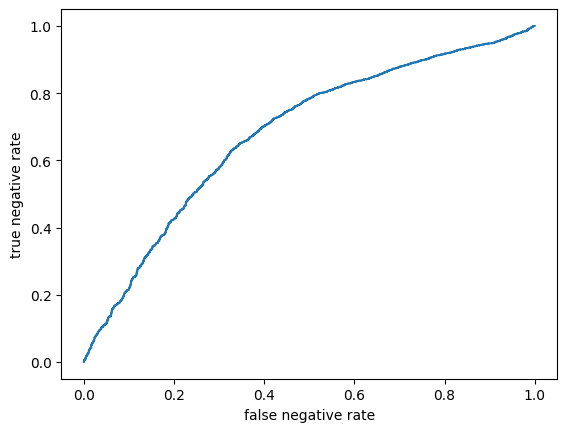

In [132]:
plt.plot(fpr_neg, tpr_neg)
plt.xlabel('false negative rate')
plt.ylabel('true negative rate')
plt.show()

In [150]:
auc_score = roc_auc_score(y_test, y_prob[:,1])
print('auc = ', auc_score)

# auc_score_neg = roc_auc_score((np.ones(np.shape(y_test))-y_test), y_prob[:,0])
# print('negative auc score = ', auc_score_neg)

auc =  0.681482012340481


AUC score of 0.68; quite poor

### [(b) Use PUL file (60/40) + `train_df` for training:]

In [39]:
train_ind = np.zeros(PUL_df.shape[0])
train_ind[:int(np.floor(PUL_df.shape[0]*0.6))] = 1 #prop. train
np.random.shuffle(train_ind)

X_PUL, y_PUL = PUL_df.to_numpy()[:,:-1], PUL_df.to_numpy()[:,-1:]

X_PUL_train, y_PUL_train = X_PUL[train_ind==1,:], y_PUL[train_ind==1]
X_PUL_test, y_PUL_test = X_PUL[train_ind==0,:], y_PUL[train_ind==0,:]

In [40]:
X1_train, y1_train = np.concatenate([np.array(train_df.iloc[:,:-1]), X_PUL_train]), np.concatenate([np.array(train_df.iloc[:,-1:]), y_PUL_train])
X1_test, y1_test = X_PUL_test, y_PUL_test

In [108]:
mlp1 = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10),
                    activation = 'relu',
                    solver = 'adam',
                    verbose = True).fit(X1_train,y1_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.55924477
Iteration 2, loss = 0.29139208
Iteration 3, loss = 0.22117616
Iteration 4, loss = 0.20915026
Iteration 5, loss = 0.20070854
Iteration 6, loss = 0.19331638
Iteration 7, loss = 0.18711276
Iteration 8, loss = 0.18265605
Iteration 9, loss = 0.17920480
Iteration 10, loss = 0.17504394
Iteration 11, loss = 0.17313134
Iteration 12, loss = 0.16985304
Iteration 13, loss = 0.16765605
Iteration 14, loss = 0.16487077
Iteration 15, loss = 0.16344621
Iteration 16, loss = 0.16196618
Iteration 17, loss = 0.16021931
Iteration 18, loss = 0.15801320
Iteration 19, loss = 0.15618093
Iteration 20, loss = 0.15528583
Iteration 21, loss = 0.15392939
Iteration 22, loss = 0.15088660
Iteration 23, loss = 0.14992218
Iteration 24, loss = 0.14986731
Iteration 25, loss = 0.14754133
Iteration 26, loss = 0.14511670
Iteration 27, loss = 0.14479812
Iteration 28, loss = 0.14488288
Iteration 29, loss = 0.14122364
Iteration 30, loss = 0.14026534
Iteration 31, loss = 0.13930781
Iteration 32, los

In [109]:
y1_pred = mlp1.predict(X1_test)

In [110]:
print(accuracy_score(y1_test,y1_pred))
#confusion matrix
mat = confusion_matrix(y1_test, y1_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

0.7412337662337662
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             1938          461
Cazyme                  336          345


**1 layer:**

- 66.4% accuracy; still much worse than trivial classifier

- Positive prediction really poor

**2 layers:** (100,100)

- Relu: 73.6%

**3 layers:** (100,100,100)

- Relu: 76.7% , poor positive prediction (<50%)

**4:**
- Relu: 75.2%, poor positive prediction (50%)

### (c) Only use PUL file for training and testing: (60/40)

In [99]:
X2_train, y2_train = X_PUL_train, y_PUL_train
X2_test, y2_test = X_PUL_test, y_PUL_test

In [114]:
mlp2 = MLPClassifier(hidden_layer_sizes=(100,100),
                    activation = 'relu',
                    solver = 'adam',
                    verbose = True).fit(X2_train,y2_train)

c:\Users\alpha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.55567637
Iteration 2, loss = 0.48351977
Iteration 3, loss = 0.46832773
Iteration 4, loss = 0.46029756
Iteration 5, loss = 0.45292093
Iteration 6, loss = 0.44632938
Iteration 7, loss = 0.43771742
Iteration 8, loss = 0.43126449
Iteration 9, loss = 0.42326714
Iteration 10, loss = 0.41405291
Iteration 11, loss = 0.40557543
Iteration 12, loss = 0.39433457
Iteration 13, loss = 0.38140771
Iteration 14, loss = 0.37806976
Iteration 15, loss = 0.36222290
Iteration 16, loss = 0.34947108
Iteration 17, loss = 0.33497619
Iteration 18, loss = 0.33345877
Iteration 19, loss = 0.31490704
Iteration 20, loss = 0.30467610
Iteration 21, loss = 0.29570629
Iteration 22, loss = 0.29469141
Iteration 23, loss = 0.28360093
Iteration 24, loss = 0.26760903
Iteration 25, loss = 0.25455942
Iteration 26, loss = 0.25855992
Iteration 27, loss = 0.24419306
Iteration 28, loss = 0.23548279
Iteration 29, loss = 0.23478562
Iteration 30, loss = 0.22276626
Iteration 31, loss = 0.21173582
Iteration 32, los

In [115]:
y2_pred = mlp2.predict(X2_test)

In [117]:
print(accuracy_score(y2_test,y2_pred))
mat = confusion_matrix(y2_test, y2_pred)
cfmat_df = pd.DataFrame(np.array(mat))
index_, columns_ = ['Not_cazyme','Cazyme'], ['Pred_not_cazyme', 'Pred_cazyme']
cfmat_df.index, cfmat_df.columns = index_, columns_

print(cfmat_df)

0.7707792207792208
            Pred_not_cazyme  Pred_cazyme
Not_cazyme             2048          351
Cazyme                  355          326


- 1 layer (10 neurons): 80.7% accuracy, 

- 2 layers: 78.3% accuracy (100,100); 78.7% (10,10)
- poor positive prediction

- 3 layers: 79.7% (100,100,100); 78.2% (10,10,10) 

- 4 layers: 77.0% (10,10,10,10)



Fewer neurons lead to poorer positive prediction (why?)
- (10,10): 35.4%
- (3,3): 30.4%

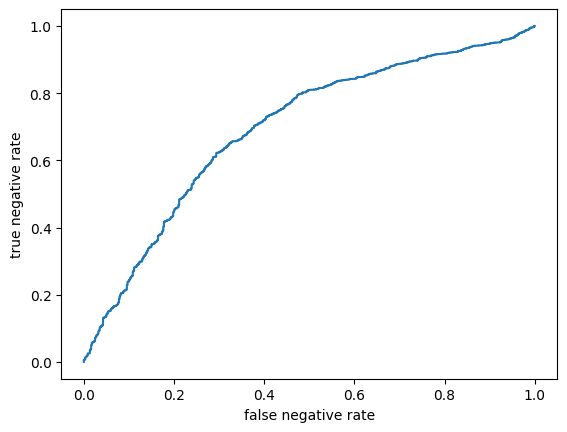

In [151]:
y2_prob = mlp.predict_proba(X2_test)
fpr2, tpr2, thresholds2 = roc_curve(y2_test, y2_prob[:,0], pos_label=0)
plt.plot(fpr2, tpr2)
plt.xlabel('false negative rate')
plt.ylabel('true negative rate')
plt.show()

In [153]:
auc2_score = roc_auc_score(y2_test, y2_prob[:,1])
print('auc = ', auc2_score)

auc =  0.694573852663769


AUC score = 0.69; not much better than in (a)